In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import huggingface_hub
huggingface_hub.login()

In [ ]:
#무작위 10개 복원 추출 3회
import pandas as pd
path = '/content/gdrive/MyDrive/Colab Notebooks/LLM평가/test.csv'
df = pd.read_csv(path)
for i in range(3):
  print(f'\n복원 추출 {i+1}회')
  df = df.sample(n=10, replace=True)[['document','summary']]
  print(df)
  df.to_csv(f'/content/gdrive/MyDrive/Colab Notebooks/LLM평가/eval{i+1}.csv', index=False,encoding='utf-8-sig')


복원 추출 1회
                                               document  \
2450  후지필름일렉트로닉이미징코리아가 초망원 줌렌즈 XF150 600㎜F5.6 8 R LM...   
522   빗썸·코인원·코빗 등에 100만원 이상 입출금 국내 대다수 거래소와 연동 파이낸셜뉴...   
1823  서울 연합뉴스 황광모 기자 허창수 전국경제인연합 회장 앞줄 오른쪽에서 다섯 번째 과...   
2449  물가 고공행진이 이어지면서 대형마트가 물가 안정의 최전선에 나섰다. 이마트는 주요 ...   
2620  용인 뉴스1 경기사진공동취재단 5일 오전 용인시 처인구 용인 반도체 클러스터 조성사...   
1977  강덕원 일동제약 신임 생산본부장 사진 일동제약 일동제약이 생산본부장에 강덕원 부사장...   
240   한화투자증권은 다음달 31일까지 ‘여름을 설레게 할 주식 투자혜택’ 이벤트를 실시한...   
2396  3일 서울 송파구에 위치한 한 공인중개사 사무소에 아파트 매매 및 전·월세 가격표가...   
542   지난 1일 서울 소공동 롯데호텔에서 열린 ‘2022 한국서비스대상 시상식’에서 롯데...   
2640  코스닥 상장 날개 달았다…2023년 기술특례상장 도전 롯데그룹 대홍기획 마케팅에 블...   

                                                summary  
2450  후지필름일렉트로닉이미징코리아가 스포츠 경기 야생 동물 공연장 등에 적합한 초망원 줌...  
522   가상자산 사업자가 가상자산을 보낸 사람과 받은 사람 정보를 모두 확보해 자금세탁이나...  
1823  코월19 여파로 2년 연속 열리지 못하다 3년 만에 재개된 한일재계회의가 신종 코로...  
2449  4 고공행진이 이어지면서 대형마트가 물가 안정의 최전선에 나섰는데 이마트는 주요 상...  
2620  5일 김동연 경기도지사 등 인근 지자체장들이 5일 오전 용인시 처인구 용인 반도

G-eval 4
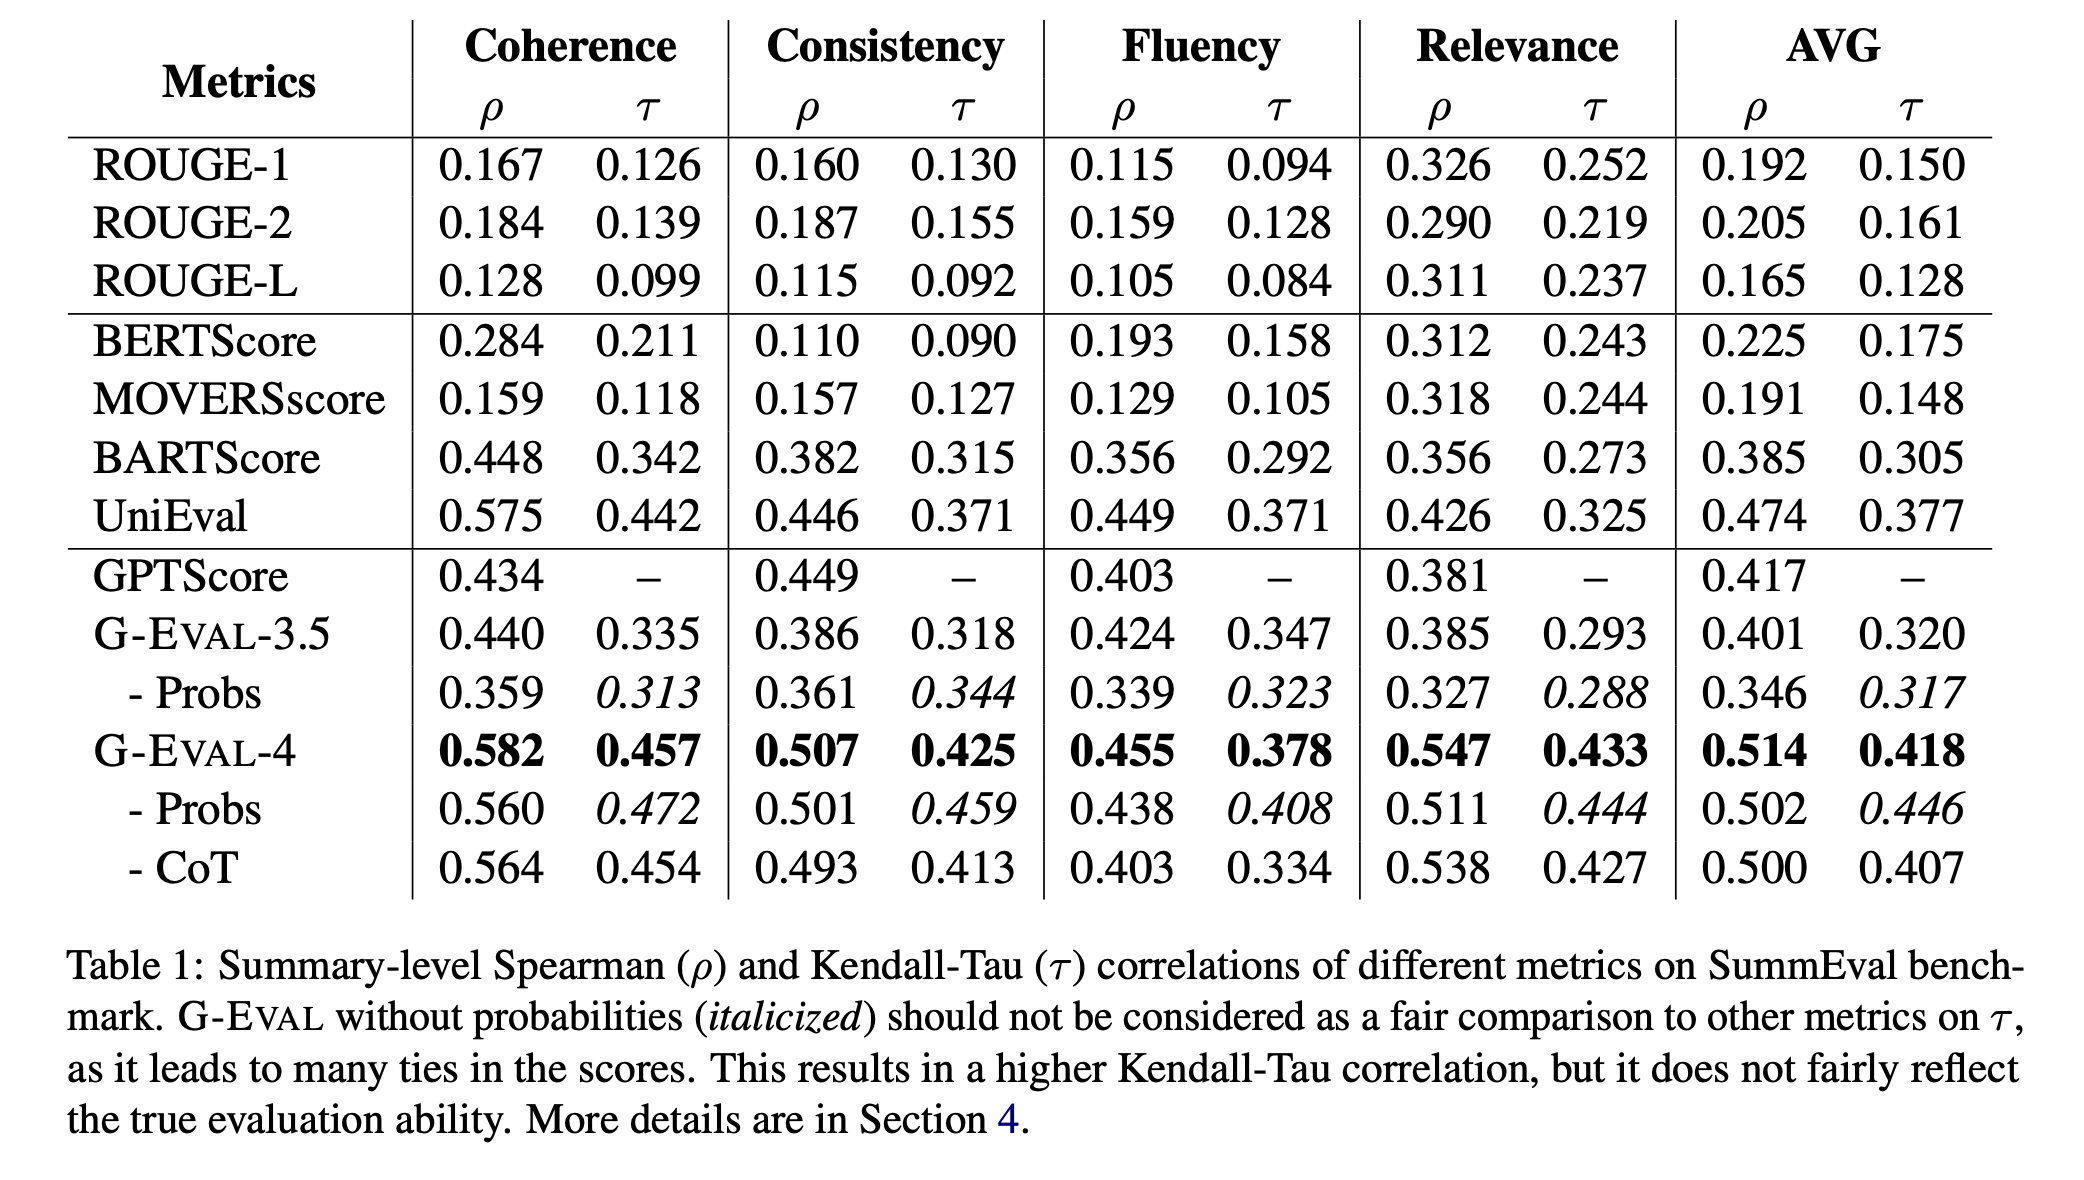

In [ ]:
# Install
!pip install deepeval

- coherence (일관성): 요약이 논리적이고 일관성 있게 표현되었는지 평가합니다.
- coherence_reason (일관성 이유): 요약의 일관성에 대한 이유를 설명합니다.
- faithfulness (신뢰성): 원본 텍스트의 정보를 충실히 반영하고 있는지를 평가합니다.
- contextual_relevancy (문맥상 적절성): 요약이 주어진 문맥에 적합하게 표현되었는지를 평가합니다.
- hallucination (환각): 요약이 없는 정보나 오류를 포함하고 있는지를 평가합니다.
- summarization (요약): 요약의 전반적인 품질을 평가합니다.
- toxicity(혐오감) : 텍스트가 혐오감을 유발할 수 있는 정도를 측정하는 지표

In [ ]:
# Set OpenAI API key as env variable
#export OPENAI_API_KEY="sk-proj-OpYbDE4qjzkePzzCnw1zT3BlbkFJC9tJgfWwGWXQrf9ruCp2"
import os
# OpenAI API 키 설정
os.environ['OPENAI_API_KEY'] = 'api key'
import openai
# 환경 변수에서 API 키 가져오기
api_key = os.getenv('OPENAI_API_KEY')
openai.api_key = api_key

In [ ]:
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval, FaithfulnessMetric, ContextualRelevancyMetric, HallucinationMetric, SummarizationMetric, ToxicityMetric
def Coherence(input, llm_output):
  try:
    test_case = LLMTestCase(input=input, actual_output=llm_output)
    coherence_metric = GEval(
      name="Coherence",
      criteria="Coherence - the collective quality of all sentences in the actual output",
      evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
    )
    coherence_metric.measure(test_case)
    return coherence_metric.score, coherence_metric.reason
  except:
    return 'error'

def Faithfulness(input, llm_output):
  try:
    test_case=LLMTestCase(input=input,actual_output=llm_output,retrieval_context=["..."])
    metric = FaithfulnessMetric(threshold=0.5)
    metric.measure(test_case)

    if not metric.is_successful(): #성공적이지 않은 경우
      print(f'Faithfullness is not successful : {metric.reason}')
    return metric.score, metric.reason
  except:
    return 'error', 'error'
#Context없으면 0점 처리: The score is 0.00 because the input contains various news headlines and snippets
#that are unrelated to any specific single topic, making it impossible to determine relevance to a single context.
def Contextual_relevancy(input, llm_output):
  test_case=LLMTestCase(input=input,actual_output=llm_output,retrieval_context=["..."])
  metric = ContextualRelevancyMetric(threshold=0.5)
  metric.measure(test_case)
  if not metric.is_successful():
    print(f'Contextual relevancy is not successful : {metric.reason}')
  return metric.score, metric.reason

#Context없으면 1점처리 : The score is 1.00 because the actual output does not provide enough information
#to determine if it agrees with the context, indicating a high level of uncertainty and potential hallucination.
def Hallucination(input, llm_output):
  test_case=LLMTestCase(input=input,actual_output=llm_output,context=["..."])
  # Note that 'context' is not the same as 'retrieval_context'.
  # While retrieval context is more concerned with RAG pipelines,
  # context is the ideal retrieval results for a given input,
  # and typically resides in the dataset used to fine-tune your LLM
  metric = HallucinationMetric(threshold=0.5)
  metric.measure(test_case)
  if not metric.is_successful(): #성공적이지 않은 경우
    print(f'Hallucination is not successful : {metric.reason}')
  return metric.score

def Toxicity(input, llm_output):
  try:
    metric = ToxicityMetric(threshold=0.5)
    test_case = LLMTestCase(input=input,actual_output = llm_output)
    metric.measure(test_case)
    if not metric.is_successful(): #성공적이지 않은 경우
      print(f'Toxicity is not successful : {metric.reason}')

    return metric.score
  except:
    return 'error'

def Summarization(input, llm_output):
  try:
    test_case = LLMTestCase(input=input, actual_output=llm_output)
    metric = SummarizationMetric(threshold=0.5)
    metric.measure(test_case)
    if not metric.is_successful(): #성공적이지 않은 경우
      print(f'Summarization is not successful : {metric.reason}')

    return metric.score
  except:
    return 'error'

#ours: 'KETI-AIR-Downstream/long-ke-t5-base-summarization'
def measure(df, df_eval):
  #input: input to your LLM, actual_output: your LLM output
  model = ['ours_finetuned'] #['summary', 'ChatGPT4o', 'ChatGPT35', 'Claude', 'Gemini', 'ours'] #칼럼 모델
  for i in range(len(df)):
    #평균 취할 것 초기화
    coherence = 0 ; faithfullness = 0 ; toxicity = 0 ; summarization = 0;
    for j in range(1):
      for m in model: #5번 점수매겨서 평균
        input = df['document'][i]; llm_output = df[m][i]
        df_eval.loc[i, 'coherence_'+m+'_'+str(j+1)+'th'] = Coherence(input, llm_output)[0]
        df_eval.loc[i, 'faithfullness_'+m+'_'+str(j+1)+'th'] = Faithfulness(input, llm_output)[0]
        df_eval.loc[i, 'toxicity_'+m+'_'+str(j+1)+'th'] = Toxicity(input, llm_output)
        df_eval.loc[i, 'summarization_'+m+'_'+str(j+1)+'th'] = Summarization(input, llm_output)
        #누적해서 평균 출력용
        #coherence += df_eval.loc['coherence_'+m+'_'+str(j+1)+'th', i]
        #faithfullness += df_eval.loc['faithfullness_'+m+'_'+str(j+1)+'th', i]
        #toxicity += df_eval.loc['toxicity_'+m+'_'+str(j+1)+'th', i]
        #summarization += df_eval.loc['summarization_'+m+'_'+str(j+1)+'th', i]

    print(f'{j+1}번째 score: {m}')
    #print(f'coherence={coherence/5}, faithfulness={faithfullness/5}, toxicity={toxicity/5}, summarization={summarization/5}')

    #df_eval.loc['coherence_'+m+'_avg', i] = coherence/5
    #df_eval.loc['faithfullness_'+m+'_avg', i] = faithfullness/5
    #df_eval.loc['toxicity_'+m+'_avg', i] = toxicity/5
    #df_eval.loc['summarization_'+m+'_avg', i] = summarization/5

  return df_eval


In [ ]:
import pandas as pd
path = '/content/gdrive/MyDrive/Colab Notebooks/LLM평가/'
df1 = pd.read_csv(path+'eval1.csv')
df2 = pd.read_csv(path+'eval1.csv')
df3 = pd.read_csv(path+'eval1.csv')
df1.head()

,document,summary,ChatGPT4o,ChatGPT35,Claude,Gemini,ours
0,후지필름일렉트로닉이미징코리아가 초망원 줌렌즈 XF150 600㎜F5.6 8 R LM...,후지필름일렉트로닉이미징코리아가 스포츠 경기 야생 동물 공연장 등에 적합한 초망원 줌...,후지필름일렉트로닉이미징코리아는 초망원 줌렌즈 XF150-600㎜F5.6-8 R LM...,"후지필름일렉트로닉이미징코리아가 7일, 초망원 줌렌즈 XF150-600mm F5.6 ...",후지필름일렉트로닉이미징코리아가 X마운트 렌즈 라인업 중 가장 긴 초점거리를 자랑하는...,후지필름 망원 줌렌즈 XF150-600mm F5.6-8 R LM OIS WR 출시,7일 후지필름일렉트로닉이미징코리아는 X마운트 렌즈 라인업 중 가장 긴 초점거리를 자...
1,빗썸·코인원·코빗 등에 100만원 이상 입출금 국내 대다수 거래소와 연동 파이낸셜뉴...,가상자산 사업자가 가상자산을 보낸 사람과 받은 사람 정보를 모두 확보해 자금세탁이나...,"포블게이트는 코드 CODE 의 자금이동추적 트래블룰 솔루션과 연동을 완료해 빗썸, ...","포블게이트는 7일, 빗썸·코인원·코빗을 포함한 국내 대다수 거래소와 CODE의 자금...",가상자산 거래소 포블게이트가 코드(CODE)의 트래블룰 솔루션과 연동을 완료해 빗썸...,"포블게이트, 빗썸·코인원·코빗 등 국내 대다수 거래소와 연동",가상자산 거래소 포블게이트는 지난 7일 코드 CODE 의 자금이동추적 트래블룰 솔루...
2,서울 연합뉴스 황광모 기자 허창수 전국경제인연합 회장 앞줄 오른쪽에서 다섯 번째 과...,코월19 여파로 2년 연속 열리지 못하다 3년 만에 재개된 한일재계회의가 신종 코로...,한일재계회의가 4일 서울 여의도 전경련 회관에서 3년 만에 재개되었다.,허창수 전국경제인연합 회장과 도쿠라 마사카즈 게이단렌 회장을 포함한 양국 단체 회장...,전국경제인연합회와 일본경제단체연합회가 3년 만에 한일재계회의를 재개했다.,"한일재계, 3년 만에 제29회 한일재계 회의 개최",신종 코로나바이러스감염증 코로나19 여파로 2년 연속 열리지 못하다 3년 만에 재개...
3,물가 고공행진이 이어지면서 대형마트가 물가 안정의 최전선에 나섰다. 이마트는 주요 ...,4 고공행진이 이어지면서 대형마트가 물가 안정의 최전선에 나섰는데 이마트는 주요 상...,이마트는 물가 안정화를 위해 주요 상품 가격을 평균 13% 인하하는 '가격의 끝' ...,"이마트는 4일, 물가 상승에 대응하기 위해 ‘가격의 끝’ 프로젝트를 시작한다고 발표...",대형마트들이 물가 안정을 위해 주요 상품 가격 인하와 최저가 정책을 실시하고 있다.,"대형마트, 물가 안정 위해 '가격의 끝' 프로젝트 진행",이마트는 주요 상품 가격을 인하하고 상시 최저가로 제공하는 ‘가격의 끝’ 프로젝트를...
4,용인 뉴스1 경기사진공동취재단 5일 오전 용인시 처인구 용인 반도체 클러스터 조성사...,5일 김동연 경기도지사 등 인근 지자체장들이 5일 오전 용인시 처인구 용인 반도체 ...,김동연 경기도지사 등이 5일 용인 반도체 클러스터 조성사업 현장에서 현안 문제를 토...,"김동연 경기도지사 등이 5일, 용인시 반도체 클러스터 조성사업 현장 간담회에서 현안...",김동연 경기도지사 등 인근 지자체장들이 용인 반도체 클러스터 조성사업 현장 간담회에...,용인 반도체 클러스터 조성사업 현장 간담회 개최,5일 오전 용인시 처인구 용인 반도체 클러스터 조성사업 현장 간담회에 참석한 김동연...


In [ ]:
import pandas as pd
#eval df 초기화
columns = ['coherence_summary_1th', 'coherence_ChatGPT4o_1th', 'coherence_ChatGPT35_1th', 'coherence_Claude_1th', 'coherence_Gemini_1th', 'coherence_ours_1th',
           #'coherence_summary_2th', 'coherence_ChatGPT4o_2th', 'coherence_ChatGPT35_2th', 'coherence_Claude_2th', 'coherence_Gemini_2th', 'coherence_ours_2th',
           #'coherence_summary_3th', 'coherence_ChatGPT4o_3th', 'coherence_ChatGPT35_3th', 'coherence_Claude_3th', 'coherence_Gemini_3th', 'coherence_ours_3th',
           #'coherence_summary_4th', 'coherence_ChatGPT4o_4th', 'coherence_ChatGPT35_4th', 'coherence_Claude_4th', 'coherence_Gemini_4th', 'coherence_ours_4th',
           #'coherence_summary_5th', 'coherence_ChatGPT4o_5th', 'coherence_ChatGPT35_5th', 'coherence_Claude_5th', 'coherence_Gemini_5th', 'coherence_ours_5th',

           'faithfullness_summary_1th', 'faithfullness_ChatGPT4o_1th', 'faithfullness_ChatGPT35_1th', 'faithfullness_Claude_1th', 'faithfullness_Gemini_1th', 'faithfullness_ours_1th',
           #'faithfullness_summary_2th', 'faithfullness_ChatGPT4o_2th', 'faithfullness_ChatGPT35_2th', 'faithfullness_Claude_2th', 'faithfullness_Gemini_2th', 'faithfullness_outs_2th',
           #'faithfullness_summary_3th', 'faithfullness_ChatGPT4o_3th', 'faithfullness_ChatGPT35_3th', 'faithfullness_Claude_3th', 'faithfullness_Gemini_3th', 'faithfullness_ours_3th',
           #'faithfullness_summary_4th', 'faithfullness_ChatGPT4o_4th', 'faithfullness_ChatGPT35_4th', 'faithfullness_Claude_4th', 'faithfullness_Gemini_4th', 'faithfullness_ours_4th',
           #'faithfullness_summary_5th', 'faithfullness_ChatGPT4o_5th', 'faithfullness_ChatGPT35_5th', 'faithfullness_Claude_5th', 'faithfullness_Gemini_5th', 'faithfullness_ours_5th',

           'toxicity_summary_1th', 'toxicity_ChatGPT4o_1th', 'toxicity_ChatGPT35_1th', 'toxicity_Claude_1th', 'toxicity_Gemini_1th', 'toxicity_ours_1th',
           #'toxicity_summary_2th', 'toxicity_ChatGPT4o_2th', 'toxicity_ChatGPT35_2th', 'toxicity_Claude_2th', 'toxicity_Gemini_2th', 'toxicity_ours_2th',
           #'toxicity_summary_3th', 'toxicity_ChatGPT4o_3th', 'toxicity_ChatGPT35_3th', 'toxicity_Claude_3th', 'toxicity_Gemini_3th', 'toxicity_ours_3th',
           #'toxicity_summary_4th', 'toxicity_ChatGPT4o_4th', 'toxicity_ChatGPT35_4th', 'toxicity_Claude_4th', 'toxicity_Gemini_4th', 'toxicity_ours_4th',
           #'toxicity_summary_5th', 'toxicity_ChatGPT4o_5th', 'toxicity_ChatGPT35_5th', 'toxicity_Claude_5th', 'toxicity_Gemini_5th', 'toxicity_ours_5th',

           'summarization_summary_1th', 'summarization_ChatGPT4o_1th', 'summarization_ChatGPT35_1th', 'summarization_Claude_1th', 'summarization_Gemini_1th', 'summarization_ours_1th'
           #'summarization_summary_2th', 'summarization_ChatGPT4o_2th', 'summarization_ChatGPT35_2th', 'summarization_Claude_2th', 'summarization_Gemini_2th', 'summarization_ours_2th',
           #'summarization_summary_3th', 'summarization_ChatGPT4o_3th', 'summarization_ChatGPT35_3th', 'summarization_Claude_3th', 'summarization_Gemini_3th', 'summarization_ours_3th',
           #'summarization_summary_4th', 'summarization_ChatGPT4o_4th', 'summarization_ChatGPT35_4th', 'summarization_Claude_4th', 'summarization_Gemini_4th', 'summarization_ours_4th',
           #'summarization_summary_5th', 'summarization_ChatGPT4o_5th', 'summarization_ChatGPT35_5th', 'summarization_Claude_5th', 'summarization_Gemini_5th', 'summarization_ours_5th',

           #'coherences_summary_avg', 'coherences_ChatGPT4o_avg', 'coherences_ChatGPT35_avg', 'coherences_Claude_avg', 'coherences_Gemini_avg', 'coherences_ours_avg',
           #'faithfullness_summary_avg', 'faithfullness_ChatGPT4o_avg', 'faithfullness_ChatGPT35_avg', 'faithfullness_Claude_avg', 'faithfullness_Gemini_avg', 'faithfullness_ours_avg',
           #'toxicity_summary_avg', 'toxicity_ChatGPT4o_avg', 'toxicity_ChatGPT35_avg', 'toxicity_Claude_avg', 'toxicity_Gemini_avg', 'toxicity_ours_avg',
           #'summarization_summary_avg', 'summarization_ChatGPT4o_avg', 'summarization_ChatGPT35_avg', 'summarization_Claude_avg', 'summarization_Gemini_avg', 'summarization_ours_avg'
           ]

df_eval1 = pd.DataFrame(columns=columns); df_eval2 = pd.DataFrame(columns=columns); df_eval3 = pd.DataFrame(columns=columns)


In [ ]:
df_eval1 = measure(df1, df_eval1)
df_eval1.head()
df_eval1.to_csv(path+'evaluated1_2th.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_eval2 = measure(df2, df_eval2)
df_eval2.to_csv(path+'evaluated2_2th.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_eval3 = measure(df3, df_eval3)
df_eval3.to_csv(path+'evaluated3_2th.csv', index=False, encoding='utf-8-sig')